### Import Libraries

In [1]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.utils.checkpoint as checkpoint
from pathlib import Path
from skimage.io import imread
from skimage.color import gray2rgb
import numpy as np
import torchvision as tv
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import numpy as np
import os
from sklearn.model_selection import train_test_split
import wandb
import gc

##### Set CUDA Memory Allocation Strategy

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

##### Check and Set Device (CPU/GPU)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##### Unzip the images File

In [4]:
import zipfile
from pathlib import Path

def unzip(zip_path):
    # Resolve the directory where the zip file is located
    target_directory = Path(zip_path).parent

    # Check if the zip file exists
    if not Path(zip_path).exists():
        raise FileNotFoundError(f"The zip file '{zip_path}' does not exist.")

    # Open the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Check if the contents are already extracted
        already_extracted = all(
            (target_directory / member).exists() for member in zip_ref.namelist()
        )
        if already_extracted:
            print(f"The contents of '{zip_path}' are already unzipped.")
            return

        # Extract files directly into the same directory
        print(f"Unzipping '{zip_path}'")
        zip_ref.extractall(target_directory)
        print(f"'{zip_path}' has been successfully unzipped.")


zip_file = "images.zip"
unzip(zip_file)

The contents of 'images.zip' are already unzipped.


##### Dataset Normalization Mean and Standard Deviation

In [5]:
train_mean = [0.59685254, 0.59685254, 0.59685254]
train_std = [0.16043035, 0.16043035, 0.16043035]

### Dataset Class

In [6]:
class ChallengeDataset(Dataset):
    def __init__(self, data, mode):
        """
        Args:
            data (pandas.DataFrame): DataFrame containing a single column with 'filename;crack;inactive' format.
            mode (str): Either 'train' or 'val', determines the transformation pipeline.
        """
        # Parse the data column into separate fields
        parsed_data = data.iloc[:, 0].str.split(';', expand=True)
        parsed_data.columns = ['filename', 'crack', 'inactive']
        parsed_data['crack'] = parsed_data['crack'].astype(int)
        parsed_data['inactive'] = parsed_data['inactive'].astype(int)
        self.data = parsed_data
        self.mode = mode

        # Define transformations
        if mode == 'train':
            self.transform = tv.transforms.Compose([
                tv.transforms.ToPILImage(),  # Convert image to PIL format for subsequent transforms
                #tv.transforms.Resize((300, 300)),
                tv.transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally with 50% probability
                tv.transforms.RandomVerticalFlip(p=0.5),  # Flip horizontally with 50% probability
                tv.transforms.RandomAffine(
                    degrees=(-3,3),                 # Rotate by up to ±3 degrees
                    translate=(0.02, 0.02),     # Allow up to 2% translation in both x and y directions
                    scale=(0.95, 1.05)          # Slight scaling variation to simulate minor zoom changes
                ),
                tv.transforms.ColorJitter(
                    brightness=0.15,            # Adjust brightness by up to 15%
                    contrast=0.15               # Adjust contrast by up to 15%
                ),
                tv.transforms.GaussianBlur(
                    kernel_size=5,              # Small kernel size for mild blurring
                    #sigma=(0.1, 0.5)            # Use a low sigma range to avoid erasing small cracks
                ),
                tv.transforms.ToTensor(),      # Convert image to tensor
                tv.transforms.Normalize(mean=train_mean, std=train_std)  # Normalize using training mean/std
            ])
        elif mode == 'val':
            self.transform = tv.transforms.Compose([
                tv.transforms.ToPILImage(),
                #tv.transforms.Resize((300, 300)),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(mean=train_mean, std=train_std)
            ])
        else:
            raise ValueError("Mode must be either 'train' or 'val'")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = Path(row['filename'])
        if not image_path.exists():
            raise FileNotFoundError(f"Image path {image_path} does not exist")

        # Load and preprocess the image
        image = imread(image_path)
        if image.ndim == 2:  # Convert grayscale to RGB
            image = gray2rgb(image)

        # Apply transformations
        image = self.transform(image)

        # Get the label
        label = torch.tensor([row['crack'], row['inactive']], dtype=torch.float32)

        return image, label

##### Visualize random samples

In [7]:
def visualize_random_samples(dataset, num_samples):
    """
    Visualize random samples from the dataset.

    Args:
        dataset (ChallengeDataset): The dataset instance.
        num_samples (int): Number of samples to visualize.
    """
    # Randomly select indices
    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]
    images, labels = zip(*samples)

    # Undo normalization for visualization
    mean = torch.tensor(train_mean)
    std = torch.tensor(train_std)
    images = [(img * std[:, None, None] + mean[:, None, None]).clamp(0, 1) for img in images]

    # Determine subplot arrangement
    if num_samples % 4 == 0:
        cols = 4
    elif num_samples % 3 == 0:
        cols = 3
    else:
        cols = num_samples

    rows = (num_samples + cols - 1) // cols  # Compute number of rows
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten() if num_samples > 1 else [axes]

    for i, ax in enumerate(axes):
        if i < num_samples:
            img = images[i].permute(1, 2, 0).numpy()  # Convert CHW to HWC
            ax.imshow(img)
            ax.axis("off")
            label_text = f"Crack: {labels[i][0].item()}, Inactive: {labels[i][1].item()}"
            ax.set_title(label_text, size = 20)
        else:
            fig.delaxes(ax)  # Remove unused axes for cleaner output

    plt.tight_layout()
    plt.show()

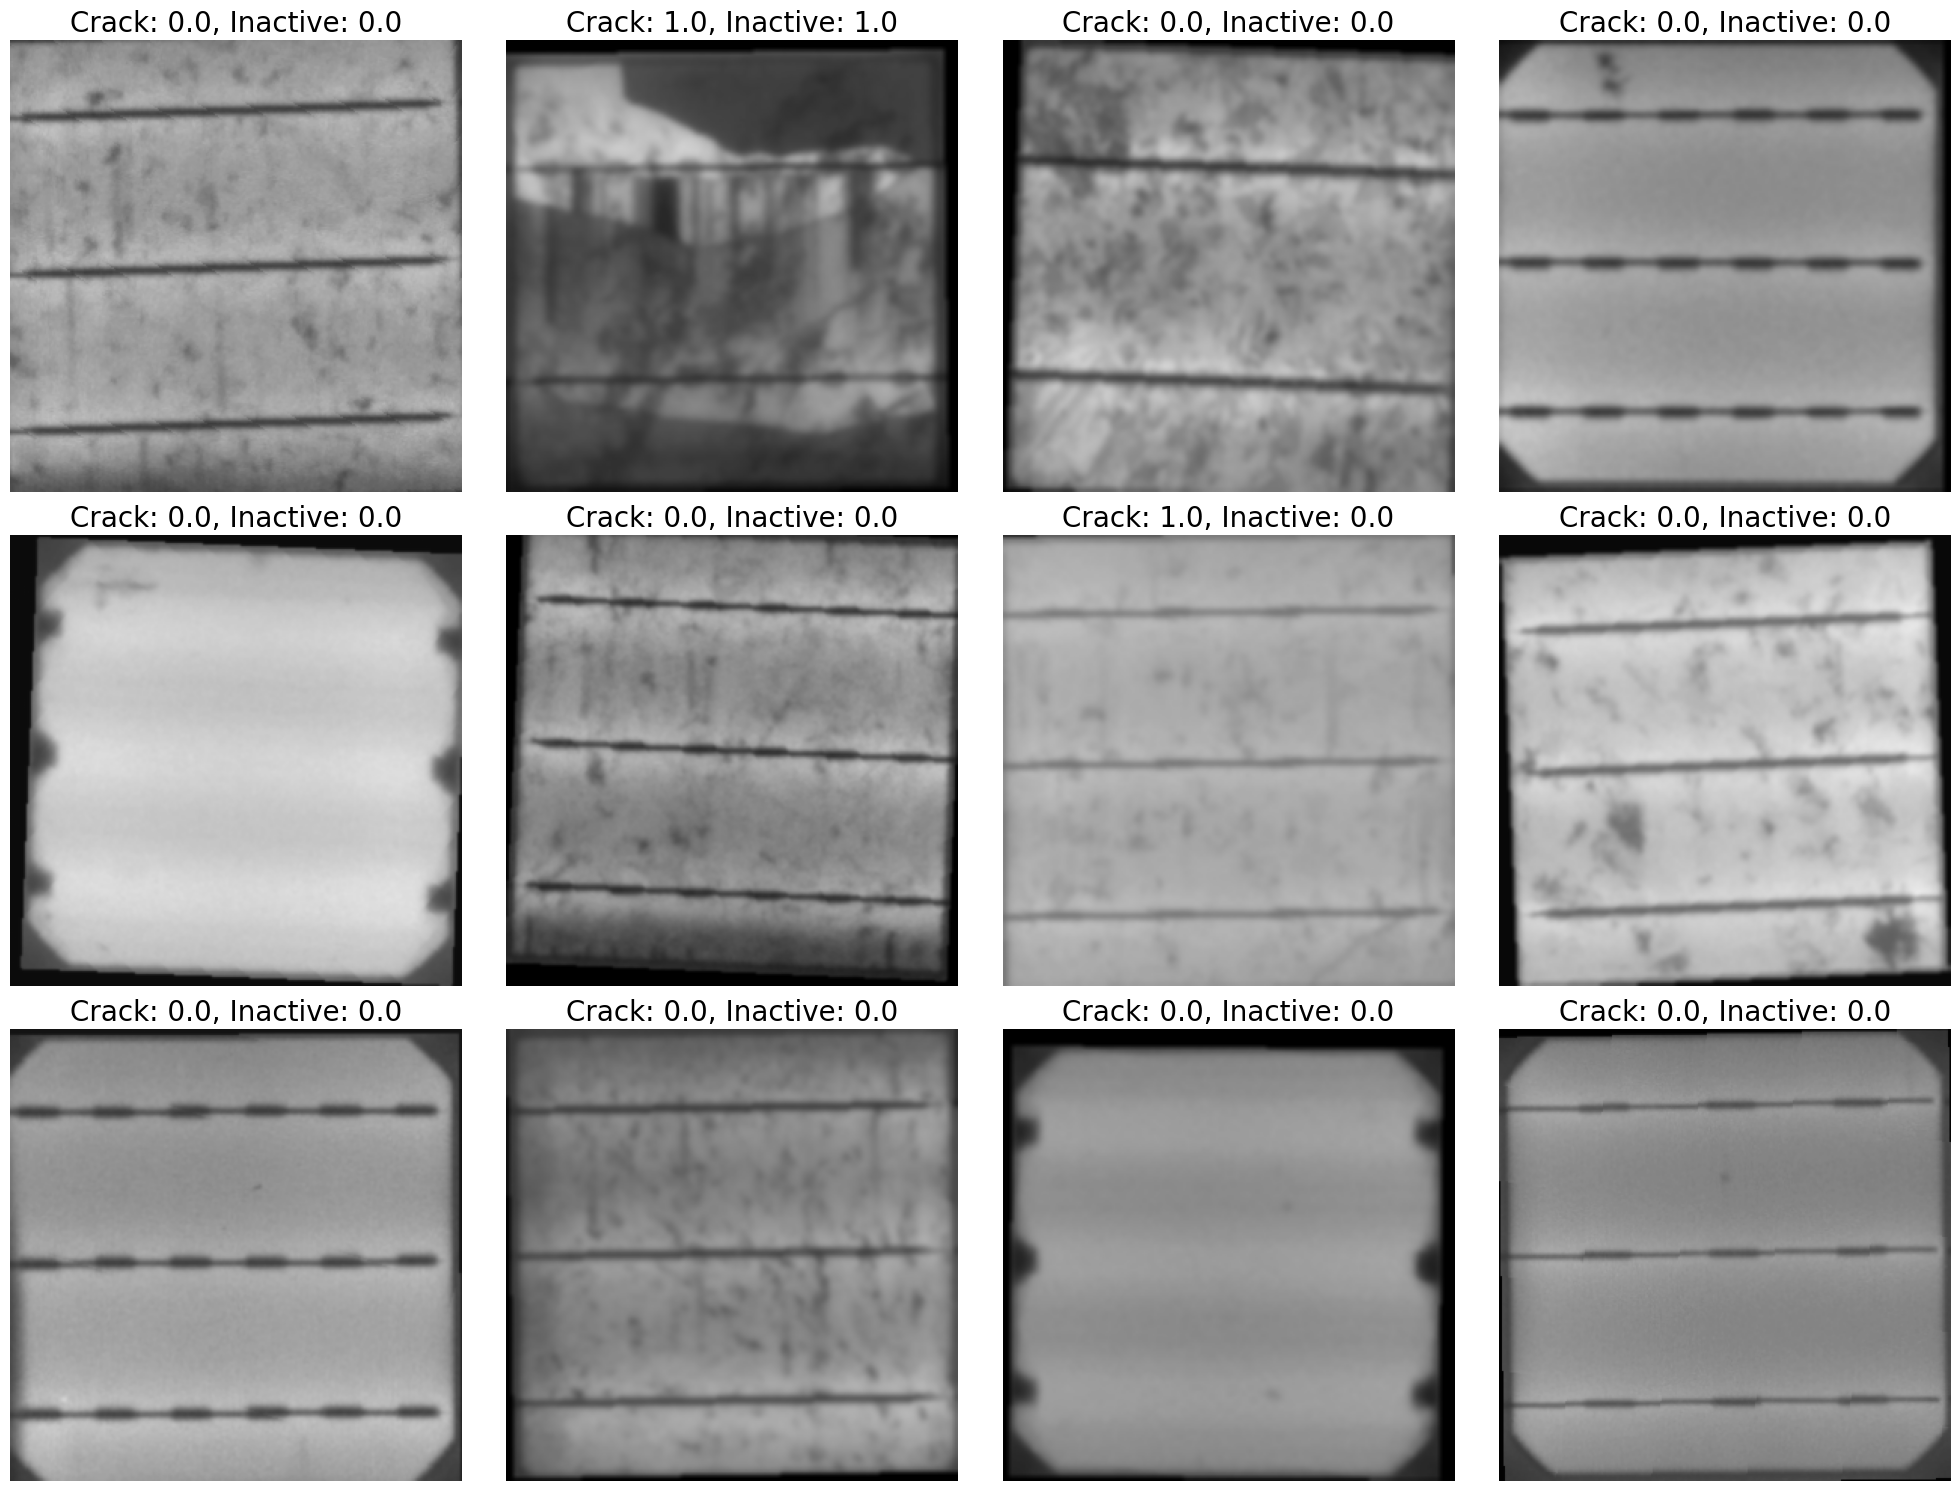

In [8]:
csv_path = "data.csv"

# Load the dataset
df = pd.read_csv(csv_path)

# Instantiate the dataset
dataset = ChallengeDataset(df, mode="train")

visualize_random_samples(dataset, num_samples=12)

In [9]:
data = dataset.data
total_images = len(data)
inactive_images = len(data[data['inactive'] == 1])
crack_images = len(data[data['crack'] == 1])

print(f"Total number of images: {total_images}")
print(f"Image shape: {dataset.__getitem__(0)[0].shape}")
print(f"Number of images with inactive label = 1: {inactive_images}")
print(f"Number of images with crack label = 1: {crack_images}")

Total number of images: 2000
Image shape: torch.Size([3, 300, 300])
Number of images with inactive label = 1: 122
Number of images with crack label = 1: 443


### ResNet

In [10]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        # First (Conv2D, BatchNorm, ReLU) sequence
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second (Conv2D, BatchNorm) sequence
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection layers (1x1 conv and bn if needed)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))

        # Skip connection and final ReLU
        out += self.shortcut(x)
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResBlocks
        self.layer1 = ResBlock(64, 64, 1)
        self.layer2 = ResBlock(64, 128, 2)
        self.layer3 = ResBlock(128, 256, 2)
        self.layer4 = ResBlock(256, 512, 2)

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Final fully connected layer
        self.fc = nn.Linear(512, 2)

        # Initialize weights
        self._initialize_weights()

        # Sigmoid activation
        self.sigmoid = nn.Sigmoid()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.sigmoid(self.fc(torch.flatten(self.avgpool(self.layer4(self.layer3(self.layer2(self.layer1(self.maxpool(F.relu(self.bn1(self.conv1(x))))))))), 1)))

In [11]:
from torchsummary import summary

model = ResNet().to(device)
summary(model, input_size=(3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
         MaxPool2d-3           [-1, 64, 75, 75]               0
            Conv2d-4           [-1, 64, 75, 75]          36,864
       BatchNorm2d-5           [-1, 64, 75, 75]             128
            Conv2d-6           [-1, 64, 75, 75]          36,864
       BatchNorm2d-7           [-1, 64, 75, 75]             128
          ResBlock-8           [-1, 64, 75, 75]               0
            Conv2d-9          [-1, 128, 38, 38]          73,728
      BatchNorm2d-10          [-1, 128, 38, 38]             256
           Conv2d-11          [-1, 128, 38, 38]         147,456
      BatchNorm2d-12          [-1, 128, 38, 38]             256
           Conv2d-13          [-1, 128, 38, 38]           8,192
      BatchNorm2d-14          [-1, 128,

### EfficientNet‑B3

In [12]:
class EfficientNetB3(nn.Module):
    def __init__(self, pretrained=True, freeze_ratio=0.5):
        """
        Args:
            pretrained (bool): If True, load pretrained weights.
            freeze_ratio (float): Fraction of the feature extractor layers to freeze.
                                  E.g., 0.5 will freeze the first half of the blocks.
        """
        super(EfficientNetB3, self).__init__()
        # Load the pre-trained EfficientNet-B3 model
        self.model = models.efficientnet_b3(
            weights=models.EfficientNet_B3_Weights.DEFAULT if pretrained else None
        )

        # Modify the classifier to output 2 classes
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 2)
        # Add a sigmoid activation function
        self.sigmoid = nn.Sigmoid()

        # Freeze a fraction of the feature extractor's layers.
        # Here, we assume self.model.features is an nn.Sequential of blocks.
        layers = list(self.model.features.children())
        num_layers = len(layers)
        freeze_layers = int(num_layers * freeze_ratio)
        print(f"Freezing {freeze_layers} out of {num_layers} feature blocks.")
        for i in range(freeze_layers):
            for param in layers[i].parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.sigmoid(self.model(x))

In [13]:
from torchinfo import summary

model = EfficientNetB3().to(device)
summary(model, input_size=(1, 3, 300, 300), device="cuda")

Freezing 4 out of 9 feature blocks.


Layer (type:depth-idx)                                       Output Shape              Param #
EfficientNetB3                                               [1, 2]                    --
├─EfficientNet: 1-1                                          [1, 2]                    --
│    └─Sequential: 2-1                                       [1, 1536, 10, 10]         --
│    │    └─Conv2dNormActivation: 3-1                        [1, 40, 150, 150]         (1,160)
│    │    └─Sequential: 3-2                                  [1, 24, 150, 150]         (3,504)
│    │    └─Sequential: 3-3                                  [1, 32, 75, 75]           (48,118)
│    │    └─Sequential: 3-4                                  [1, 48, 38, 38]           (110,912)
│    │    └─Sequential: 3-5                                  [1, 96, 19, 19]           638,700
│    │    └─Sequential: 3-6                                  [1, 136, 19, 19]          1,387,760
│    │    └─Sequential: 3-7                                 

### EfficientNet V2 Medium

In [14]:
class EfficientNetV2M(nn.Module):
    def __init__(self, pretrained=True, freeze_ratio=0.5):
        """
        Args:
            pretrained (bool): If True, load pretrained weights.
            freeze_ratio (float): Fraction of the feature extractor layers to freeze.
                                  E.g., 0.5 will freeze the first half of the blocks.
        """
        super(EfficientNetV2M, self).__init__()
        # Load the pre-trained EfficientNet V2 Medium model
        self.model = models.efficientnet_v2_m(
            weights=models.EfficientNet_V2_M_Weights.DEFAULT if pretrained else None
        )

        # Modify the classifier to output 2 classes
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 2)
        # Add a sigmoid activation function for binary classification
        self.sigmoid = nn.Sigmoid()

        # Freeze a fraction of the feature extractor's layers
        layers = list(self.model.features.children())
        num_layers = len(layers)
        freeze_layers = int(num_layers * freeze_ratio)
        print(f"Freezing {freeze_layers} out of {num_layers} feature blocks.")
        for i in range(freeze_layers):
            for param in layers[i].parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.sigmoid(self.model(x))

In [15]:
model = EfficientNetV2M().to(device)
summary(model, input_size=(1, 3, 300, 300), device="cuda")

Freezing 4 out of 9 feature blocks.


Layer (type:depth-idx)                                       Output Shape              Param #
EfficientNetV2M                                              [1, 2]                    --
├─EfficientNet: 1-1                                          [1, 2]                    --
│    └─Sequential: 2-1                                       [1, 1280, 10, 10]         --
│    │    └─Conv2dNormActivation: 3-1                        [1, 24, 150, 150]         (696)
│    │    └─Sequential: 3-2                                  [1, 24, 150, 150]         (15,696)
│    │    └─Sequential: 3-3                                  [1, 48, 75, 75]           (396,192)
│    │    └─Sequential: 3-4                                  [1, 80, 38, 38]           (1,126,048)
│    │    └─Sequential: 3-5                                  [1, 160, 19, 19]          1,686,340
│    │    └─Sequential: 3-6                                  [1, 176, 19, 19]          6,650,852
│    │    └─Sequential: 3-7                             

### ConvNeXt-Base

In [16]:
class ConvNeXtBase(nn.Module):
    def __init__(self, pretrained=True, freeze_ratio=0.5):
        """
        Args:
            pretrained (bool): If True, load pretrained weights.
            freeze_ratio (float): Fraction of the feature extractor layers to freeze.
                                  E.g., 0.5 will freeze the first half of the blocks.
        """
        super(ConvNeXtBase, self).__init__()
        # Load the pre-trained ConvNeXt-Base model
        self.model = models.convnext_base(
            weights=models.ConvNeXt_Base_Weights.DEFAULT if pretrained else None
        )

        # Modify the classifier to output 2 classes
        in_features = self.model.classifier[2].in_features
        self.model.classifier[2] = nn.Linear(in_features, 2)

        # Add a sigmoid activation function
        self.sigmoid = nn.Sigmoid()

        # Freeze a fraction of the feature extractor's layers.
        # ConvNeXt has self.model.features as an nn.Sequential block
        layers = list(self.model.features.children())
        num_layers = len(layers)
        freeze_layers = int(num_layers * freeze_ratio)
        print(f"Freezing {freeze_layers} out of {num_layers} feature blocks.")
        for i in range(freeze_layers):
            for param in layers[i].parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.sigmoid(self.model(x))

In [17]:
from torchsummary import summary

model = ConvNeXtBase().to(device)
summary(model, input_size=(3, 300, 300))

Freezing 4 out of 8 feature blocks.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 75, 75]           6,272
       LayerNorm2d-2          [-1, 128, 75, 75]             256
            Conv2d-3          [-1, 128, 75, 75]           6,400
           Permute-4          [-1, 75, 75, 128]               0
         LayerNorm-5          [-1, 75, 75, 128]             256
            Linear-6          [-1, 75, 75, 512]          66,048
              GELU-7          [-1, 75, 75, 512]               0
            Linear-8          [-1, 75, 75, 128]          65,664
           Permute-9          [-1, 128, 75, 75]               0
  StochasticDepth-10          [-1, 128, 75, 75]               0
          CNBlock-11          [-1, 128, 75, 75]               0
           Conv2d-12          [-1, 128, 75, 75]           6,400
          Permute-13          [-1, 75, 75, 128]               0
   

### Trainer class

In [18]:
class Trainer:
    def __init__(self,
                 model,                        # Model to be trained.
                 crit,                         # Loss function
                 optim=None,                   # Optimizer
                 train_dl=None,                # Training data set
                 val_test_dl=None,             # Validation (or test) data set
                 cuda=True,                    # Whether to use the GPU
                 scheduler = None,             # learning rate scheduler
                 early_stopping_patience=-1):  # The patience for early stopping
        self._model = model
        self._crit = crit
        self._optim = optim
        self._train_dl = train_dl
        self._val_test_dl = val_test_dl
        self._cuda = cuda
        self._scheduler = scheduler
        self._early_stopping_patience = early_stopping_patience

        if cuda:
            self._model = model.cuda()
            self._crit = crit.cuda()

    def save_checkpoint(self, epoch):
        # Create a unique name for this run's artifact folder
        run_id = wandb.run.id  # Each W&B run has a unique ID
        artifact_name = f"model-checkpoints-run-{run_id}"

        # Temporary file for the checkpoint
        temp_path = f"temp_checkpoint_{epoch:03d}.pth"
        torch.save(self._model.state_dict(), temp_path)

        # Create or update an artifact for this run
        artifact = wandb.Artifact(artifact_name, type="model", metadata={"epoch": epoch})
        artifact.add_file(temp_path)

        # Log the artifact to W&B
        wandb.log_artifact(artifact)

        # Clean up the temporary file
        os.remove(temp_path)

    def restore_checkpoint(self, epoch_n):
        ckp = torch.load('checkpoints/checkpoint_{:03d}.ckp'.format(epoch_n), 'cuda' if self._cuda else None)
        self._model.load_state_dict(ckp['state_dict'])

    def save_onnx(self, fn):
        m = self._model.cpu()
        m.eval()
        x = torch.randn(1, 3, 300, 300, requires_grad=True)
        y = self._model(x)
        torch.onnx.export(m,                 # model being run
              x,                         # model input (or a tuple for multiple inputs)
              fn,                        # where to save the model (can be a file or file-like object)
              export_params=True,        # store the trained parameter weights inside the model file
              opset_version=10,          # the ONNX version to export the model to
              do_constant_folding=True,  # whether to execute constant folding for optimization
              input_names = ['input'],   # the model's input names
              output_names = ['output'], # the model's output names
              dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                            'output' : {0 : 'batch_size'}})

    def train_step(self, x, y):
        # Reset gradients
        self._optim.zero_grad()

        # Forward pass
        predictions = self._model(x)

        # Calculate loss
        loss = self._crit(predictions, y)

        # Backward pass
        loss.backward()

        # Update weights
        self._optim.step()

        return loss.item()

    def val_test_step(self, x, y):
        # Forward pass
        predictions = self._model(x)

        # Calculate loss
        loss = self._crit(predictions, y)

        return loss.item(), predictions

    def train_epoch(self):
        # Set training mode
        self._model.train()

        total_loss = 0


        # Iterate through the training set
        for batch in tqdm(self._train_dl, desc="Training", leave=False):
            # Get the input and labels from batch and move to GPU if available
            x, y = batch
            if self._cuda:
                x = x.cuda()
                y = y.cuda()

            # Perform training step
            loss = self.train_step(x, y)
            total_loss += loss

        # Return average loss
        return total_loss / len(self._train_dl)

    def val_test(self):
        # Set evaluation mode
        self._model.eval()

        total_loss = 0
        predictions = []
        labels = []

        # Disable gradient computation
        with torch.no_grad():
            # Iterate through the validation set
            for batch in tqdm(self._val_test_dl, desc="Validating", leave=False):
                # Get the input and labels from batch and move to GPU if available
                x, y = batch
                if self._cuda:
                    x = x.cuda()
                    y = y.cuda()

                # Perform validation step
                loss, batch_predictions = self.val_test_step(x, y)

                # Save predictions and labels
                predictions.extend(batch_predictions.cpu().numpy())
                labels.extend(y.cpu().numpy())

                total_loss += loss

        # Calculate average loss and F1 score
        avg_loss = total_loss / len(self._val_test_dl)
        predictions = np.array(predictions) > 0.5  # Convert probabilities to binary predictions
        f1 = f1_score(labels, predictions, average='macro')
        accuracy = accuracy_score(labels, predictions)

        print(f'Validation Loss: {avg_loss:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')
        return avg_loss, f1, accuracy

    def fit(self, epochs=-1):
        assert self._early_stopping_patience > 0 or epochs > 0

        # Initialize lists for losses and counter
        train_losses = []
        val_losses = []
        val_f1_scores = []
        val_accuracies = []
        epoch_counter = 0
        best_val_loss = float('inf')
        best_val_f1 = 0
        patience_counter = 0
        previous_lr = None

        while True:
            # Check if we should stop by epoch number
            if epochs > 0 and epoch_counter >= epochs:
                break

            # Train for an epoch
            train_loss = self.train_epoch()
            val_loss, val_f1, val_accuracy = self.val_test()

            # Step the scheduler
            if self._scheduler is not None:
                self._scheduler.step(train_loss)
                current_lr = self._optim.param_groups[0]['lr']
                if previous_lr is None or current_lr!=previous_lr:
                    print(f"*********Current learning Rate is: {current_lr:.6e}*********")
                    previous_lr = current_lr

            # Save losses
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_f1_scores.append(val_f1)
            val_accuracies.append(val_accuracy)

            # Save checkpoint if validation loss improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                self.save_checkpoint(epoch_counter)

            # Early stopping check
            if self._early_stopping_patience > 0 and patience_counter >= self._early_stopping_patience:
                print(f'Early stopping triggered after epoch {epoch_counter}')
                break

            epoch_counter += 1
            print(f'Epoch {epoch_counter}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            wandb.log({"F1 score": val_f1, "train_loss": train_loss, "val_loss": val_loss, "Accuracy": val_accuracy})
            torch.cuda.empty_cache()

        return train_losses, val_losses, val_f1_scores, val_accuracies

### Weighted BCE Loss

In [19]:
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weights):
        """
        pos_weights: A tensor of positive class weights for each output dimension.
        Example: torch.tensor([w_crack, w_inactive])
        """
        super(WeightedBCELoss, self).__init__()
        self.pos_weights = pos_weights

    def forward(self, pred, target):
        """
        pred: predictions from the model (after Sigmoid), shape (batch_size, num_classes)
        target: ground truth labels, shape (batch_size, num_classes)
        """
        pos_weights = self.pos_weights.to(pred.device)

        # To avoid log(0), clip predictions to a small value within (0,1)
        eps = 1e-7
        pred = torch.clamp(pred, eps, 1.0 - eps)

        # Standard BCE loss for each element
        bce = - (target * torch.log(pred) + (1 - target) * torch.log(1 - pred))

        # Apply pos_weight only to the positive examples:
        # If target == 1, weight becomes pos_weight, else remains 1.
        # The broadcasting works over the batch dimension.
        weights = target * pos_weights + (1 - target)
        weighted_bce = bce * weights

        # Return the mean loss over all elements
        return weighted_bce.mean()

### CutMix and MixUp

In [20]:
from torch.utils.data import default_collate
from torchvision.transforms.v2 import MixUp, CutMix, RandomChoice

class IdentityTransform:
    def __call__(self, images, labels):
        return images, labels

num_classes = 2
def cutmix_or_mixup(images, labels):
    mixup = MixUp(num_classes=num_classes)
    cutmix = CutMix(num_classes=num_classes)
    identity = IdentityTransform()

    # Randomly choose between MixUp and CutMix
    augmentation = RandomChoice([mixup, cutmix, identity, identity])
    return augmentation(images, labels)

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

### Training with wandb

In [ ]:
# Load the data from the csv file and perform a train-test-split
data = pd.read_csv('data.csv')  # Assuming single column with 'filename;crack;inactive' format
train_data, val_data = train_test_split(
    data,
    test_size=0.1,
    random_state=42,
    shuffle=True
)

# Parse the training data into separate columns.
# (This parsing mirrors what is done in the ChallengeDataset.)
parsed_train = train_data.iloc[:, 0].str.split(';', expand=True)
parsed_train.columns = ['filename', 'crack', 'inactive']
parsed_train['crack'] = parsed_train['crack'].astype(int)
parsed_train['inactive'] = parsed_train['inactive'].astype(int)

# Define weights based on inverse frequency
# (These values come from the numbers: 2000 total, 443 with crack=1, 122 with inactive=1)
baseline = 1.0
w_crack = 2000 / (2 * 443)    # ~2.256
w_inactive = 2000 / (2 * 122)   # ~8.2

sample_weights = []
for _, row in parsed_train.iterrows():
    # Compute weight for the sample:
    # If a sample has crack=1, add w_crack; if inactive=1, add w_inactive.
    # The baseline ensures even negative samples are included.
    weight = baseline + row['crack'] * w_crack + row['inactive'] * w_inactive
    sample_weights.append(weight)

# Create a WeightedRandomSampler from these weights.
# Set replacement=True so samples can be repeated in an epoch.
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Set up data loading for training and validation sets
train_dataset = ChallengeDataset(
    data=train_data,
    mode='train'
)

val_dataset = ChallengeDataset(
    data=val_data,
    mode='val'
)

# Define sweep configuration with a parameter for model type.
sweep_config = {
    'method': 'grid',
    'name': 'Solar-cells',
    'metric': {
        'name': 'val_loss',  # Metric to optimize
        'goal': 'minimize'   # Objective: 'minimize' or 'maximize'
    },
    'parameters': {
        'model': {'values': ["ResNet", "EfficientNetB3", "EfficientNetV2M", "ConvNeXtBase"]}
    },
    'wandb': {
        'project': 'solar-cells',
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="solar-cells")

def run_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config

        # Create data loaders
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            sampler=sampler,
            batch_size=32,
            num_workers=4,
            collate_fn=collate_fn
        )

        val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=32,
            shuffle=False,
            num_workers=4,
        )

        # Instantiate model based on the sweep configuration
        if config.model == "ResNet":
            model = ResNet()
        elif config.model == "EfficientNetB3":
            model = EfficientNetB3(freeze_ratio=0)
        elif config.model == "EfficientNetV2M":
            model = EfficientNetV2M(freeze_ratio=0)
        elif config.model == "ConvNeXtBase":
            model = ConvNeXtBase(freeze_ratio=0)
        else:
            raise ValueError(f"Unknown model type: {config.model}")

        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        model.to(device)

        # Set up BCE loss
        criterion = torch.nn.BCELoss()

        # Group parameters for differential learning rates:
        feature_extractor_params = []
        classifier_params = []

        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue  # Skip frozen parameters
            if "classifier" in name:
                classifier_params.append(param)
            else:
                feature_extractor_params.append(param)

        # Set up AdamW optimizer with fixed weight decay of 0.00001
        optimizer = torch.optim.AdamW([
            {'params': feature_extractor_params, 'lr': 0.0001},
            {'params': classifier_params, 'lr': 0.0001}
        ], weight_decay=0.00001)

        # Set up learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-5)

        # Watch the model's weights, gradients, and more
        wandb.watch(model, criterion, log='all', log_freq=10)

        # Create trainer instance
        trainer = Trainer(
            model=model,
            crit=criterion,
            optim=optimizer,
            train_dl=train_loader,
            val_test_dl=val_loader,
            cuda=torch.cuda.is_available(),
            scheduler=scheduler,
            early_stopping_patience=15
        )

        # Train the model
        res = trainer.fit(epochs=2)

        # Print final metrics
        print(f"Final Training Loss: {res[0][-1]:.4f}")
        print(f"Final Validation Loss: {res[1][-1]:.4f}")
        print(f"Best Validation Loss: {min(res[1]):.4f} at epoch {np.argmin(res[1])}")

        # Cleanup after the run
        del model, optimizer, criterion, trainer, train_loader, val_loader  # Delete objects
        torch.cuda.empty_cache()  # Release GPU memory
        gc.collect()  # Trigger garbage collection to free CPU memory

# Run the sweep with one run per model type (total 4 runs)
wandb.agent(sweep_id, function=run_sweep, count=4)